In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img = cv2.imread('tiffney.pgm_gaussian_noise.jpg', 0)

### Define common functions

In [3]:
# Function to plot the orignal and image obtained after applying the filter
def plot_org_and_filtered_images(org, filtered, filter_name):
    plt.subplot(121), plt.imshow(org, cmap='gray'), plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(filtered, cmap='gray'), plt.title(filter_name)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
filter_sizes = [3, 5, 7] # filter_sizes are : 3x3, 5x5, 7x7}

In [4]:
# Function to convolve image with the given filter
def convolution(img, filter):
    n = img.shape[0]
    m = img.shape[1]
    f = filter.shape[0]
    s = int((f - 1)/2)
    output = np.zeros((n - s, m - s))
    for i in range(s, n - s):
        for j in range(s, m - s):
            output[i, j] = np.sum(np.multiply(img[i-s:i+s+1,j-s:j+s+1], filter))
    return output

### Applying Low-Pass Filtering (Averaging) 

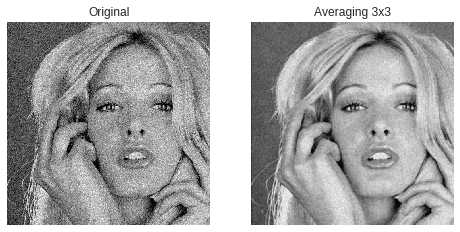

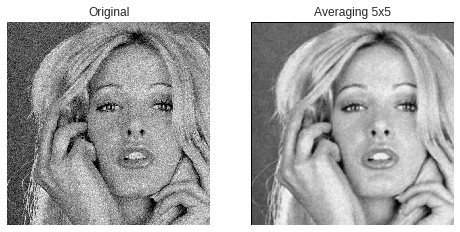

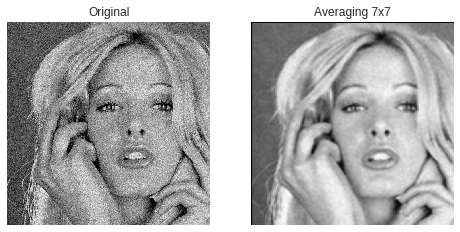

In [37]:
for filter_size in filter_sizes:
    # obtain the mask
    kernel = np.ones((filter_size, filter_size), np.float32)/(filter_size*filter_size)
    # convolve mask with the image to obtain the output
    output = convolution(img, kernel)
    # print the orignal and the output images
    plot_org_and_filtered_images(img, output, "Averaging " + str(filter_size) + "x" + str(filter_size))

### Applying Gaussian Filtering

In [38]:
# function to obtain the gaussian kernel
def gaussian_kernel(n, sigma):
    kernel = np.zeros((n, n))
    k = n//2
    for i in range(-k, k+1):
        for j in range(-k,k+1):
            kernel[i+k, j+k] = np.exp(-(i**2 + j**2)/(2.0*sigma**2))/(2*np.pi*sigma**2)
    return kernel/kernel.sum()
gaussian_kernel(5, 1)

array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]])

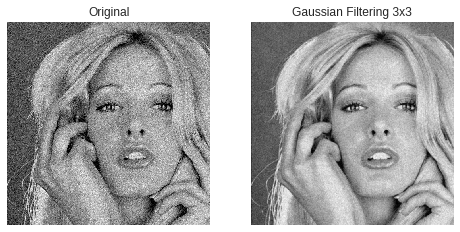

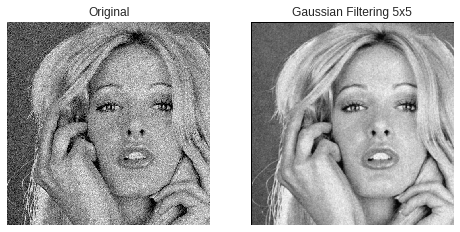

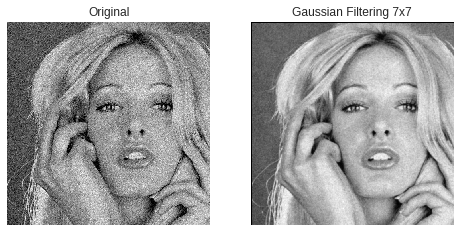

In [39]:
for filter_size in filter_sizes:
    # obtain the gaussian kernel, sigma = 1.0
    kernel = gaussian_kernel(filter_size, 1.0)
    # obtain the output using Gaussian Filter
    output = convolution(img, kernel)
    # plot the orignal and filtered images
    plot_org_and_filtered_images(img, output, "Gaussian Filtering " + str(filter_size) + "x" + str(filter_size))

### Applying Bilateral Filtering

#### In case of bilateral filtering, the kernel also depends on the nearby pixel intensity values not just on the distance from the center pixel. So, kernel keeps on changing as it is convolved with the image.

In [5]:
# Function to perform convolution of image with a bilateral filter
def convolve_bilateral(img, g_filter, sigma):
    n = img.shape[0]
    m = img.shape[1]
    f = g_filter.shape[0]
    s = int((f - 1)/2)
    output = np.zeros((n - s, m - s))
    # filter to store pixel intensity square differences
    b_filter = np.zeros((f, f))
    for i in range(s, n - s):
        for j in range(s, m - s):
            # take pixel intensity differences and multiply with gaussian filter to obtain bilateral filter
            b_filter = np.exp(-((img[i-s:i+s+1, j-s:j+s+1] - img[i, j]))**2/(2*sigma**2))/(2*np.pi*sigma**2)
            filter = np.multiply(g_filter, b_filter)
            filter = filter/np.sum(filter)
            output[i, j] = np.sum(np.multiply(img[i-s:i+s+1,j-s:j+s+1], filter))
    return output

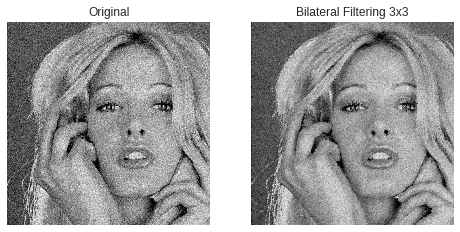

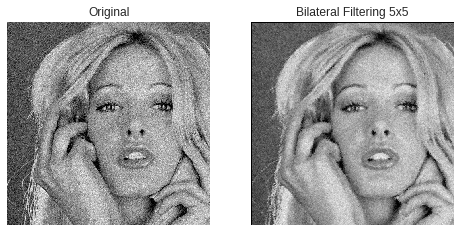

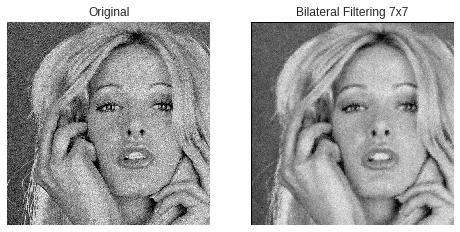

In [41]:
for filter_size in filter_sizes:
    # first obtain the gaussian_kernel, sigma = 3.0
    g_kernel = gaussian_kernel(filter_size, 3.0)
    # now convolve with the image, changing the kernel at each operation, sigma = 3.0
    output = convolve_bilateral(img, g_kernel, 3.0)
    # plot the orignal and filtered images
    plot_org_and_filtered_images(img, output, "Bilateral Filtering " + str(filter_size) + "x" + str(filter_size))

### Applying Non-Local Means Filtering

#### In case of non-local means filtering, the kernel is similar to the bilateral one, except for the fact that we don't rely on individual pixel intensities as they can also have noise, so while calculating the kernel based on pixel intensity difference from center pixel, we consider a window (generally 7x7) around the two pixels and take the average of square difference between the two 7x7 pixel intensities. 

In [6]:
# Function to perform convolution of image with a non-local means filter
def convolve_nlm(img, filter_size, window_size, sigma):
    n = img.shape[0]
    m = img.shape[1]
    f = filter_size
    w = window_size
    s = int((f - 1)/2) + int((w - 1)/2)
    output = np.zeros((n - s, m - s))
    # filter to store pixel intensity square differences
    nlm_filter = np.zeros((f, f))
    pisd = np.zeros((f, f))
    for i in range(s, n - s):
        for j in range(s, m - s):
            # take pixel intensity square differences (pisd) and then the avg for the entire w*w window
            for k in range(-(f//2), f//2+1):
                for l in range(-(f//2), f//2+1):
                    pisd[k+f//2, l+f//2] = np.average(np.square(img[i+k-(w//2):i+k+w//2+1, j+l-(w//2):j+l+w//2+1] - img[i-(w//2):i+w//2+1, j-(w//2):j+w//2+1]))
            nlm_filter = np.exp(-(pisd**2)/(2*sigma**2))/(2*np.pi*sigma**2)
            nlm_filter = nlm_filter/np.sum(nlm_filter)
            output[i, j] = np.sum(np.multiply(img[i-(f//2):i+f//2+1,j-(f//2):j+f//2+1], nlm_filter))
    return output

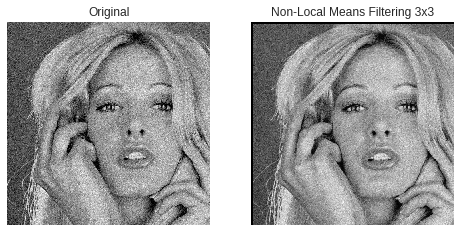

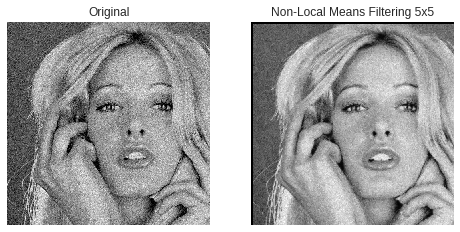

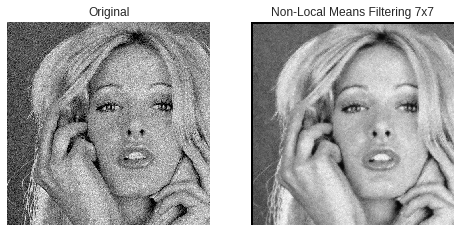

In [46]:
for filter_size in filter_sizes:
    # now convolve with the image, changing the kernel at each operation, window size = 7, sigma = 40.0
    output = convolve_nlm(img, filter_size, 7, 40.0)
    # plot the orignal and filtered images
    plot_org_and_filtered_images(img, output, "Non-Local Means Filtering " + str(filter_size) + "x" + str(filter_size))